# Exploring Dandiset 001349: From Initial Formation to Developmental Refinement—GABAergic Inputs Shape Neuronal Subnetworks in the Primary Somatosensory Cortex

*This notebook was generated with the assistance of AI (OpenAI's GPT-4). Users should exercise due diligence and independently validate any code or results produced herein.*

---

## Overview

This notebook provides an introduction and guided exploration of [Dandiset 001349: "From Initial Formation to Developmental Refinement: GABAergic Inputs Shape Neuronal Subnetworks in the Primary Somatosensory Cortex"](https://dandiarchive.org/dandiset/001349/0.250520.1729).

The dataset features two-photon calcium imaging and synchronized behavioral recordings from developing mouse somatosensory cortex across multiple sessions and subjects, stored in NWB format.

### What you’ll find here:
- A structured tour of the Dandiset with relevant metadata.
- Examples of exploring the file structure with the DANDI API.
- Step-by-step code illustrating how to stream and visualize NWB data, including cell segmentation structures and neural activity traces.
- Explanatory notes for each major step, helping you to adapt the code to your own analysis needs.

---

## Summary of Notebook Coverage

- Requirements and imports
- Dandiset overview and DANDI API exploration
- Navigating and summarizing NWB file organization
- Session and subject metadata extraction
- Visualizing cell segmentation structure (ROIs)
- Extracting and plotting neural activity traces (ΔF/F and event-like)
- Guidance on behavioral synchronization/access
- Analysis notes and practical recommendations

## Required Packages

To follow along, you will need the following Python packages (assumed installed):

- numpy
- pandas
- matplotlib
- pynwb
- h5py
- dandi
- remfile

No need for any pip install commands—just import and go!

## 1. Dandiset Overview and Metadata

**Title:** From Initial Formation to Developmental Refinement: GABAergic Inputs Shape Neuronal Subnetworks in the Primary Somatosensory Cortex  
**DOI:** [10.48324/dandi.001349/0.250520.1729](https://doi.org/10.48324/dandi.001349/0.250520.1729)  

**Description:**  
Calcium imaging (two-photon) in primary somatosensory cortex of developing mice (P11–P21), with synchronized behavioral video. Imaging and behavior are time-aligned via an LED signal, and data is provided in NWB format, with multiple cells and sessions per subject.

**Species:** Mus musculus (mouse)  
**Modalities:** Two-photon calcium imaging, behavioral synchronization  
**Subjects:** 32  
**Files:** 361 (approx. 9 GB total, each ~20–45 MB)

See the [Dandiset landing page](https://dandiarchive.org/dandiset/001349/0.250520.1729) for full context and data download.

## 2. Exploring Dandiset File Structure with the DANDI API

We'll use the DANDI API to explore the Dandiset remotely without downloading the full dataset.

In [1]:
from dandi.dandiapi import DandiAPIClient
import pandas as pd

# Connect to the DANDI archive and list available NWB files
dandiset_id = "001349"
dandiset_version = "0.250520.1729"

client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List first 20 NWB files to illustrate file organization
assets = dandiset.get_assets_by_glob("*.nwb")
asset_list = list(asset for _, asset in zip(range(20), assets))  # first 20 NWB files

# Build a table of file paths and sizes
summary = []
for asset in asset_list:
    summary.append({
        "Path": asset.path,
        "Size (MB)": round(asset.size / 1e6, 2)
    })

file_summary = pd.DataFrame(summary)
file_summary

,Path,Size (MB)
0,sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb,26.63
1,sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-1_ophys.nwb,28.30
2,sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-2_ophys.nwb,33.31
3,sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-3_ophys.nwb,38.86
4,sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-0_ophys.nwb,36.63
5,sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-4_ophys.nwb,44.80
6,sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-1_ophys.nwb,35.53
7,sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-11_ophys.nwb,30.92
8,sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-12_ophys.nwb,39.53
9,sub-C57-C2-1-AL/sub-C57-C2-1-AL_ses-13_ophys.nwb,29.57


Each file path encodes subject and session, and file sizes range from ~19 MB to ~45 MB. Multiple sessions are available for some animals, making this dataset ideal for longitudinal and cross-session analyses.

## 3. Loading and Summarizing NWB Data Remotely

We'll stream a representative NWB file directly from the DANDI archive.

In [2]:
import pynwb
import h5py
import remfile

# Select a representative NWB file path from the Dandiset
remote_nwb_path = "sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb"
asset = next(dandiset.get_assets_by_glob(remote_nwb_path))
nwb_url = asset.download_url

# Stream the NWB file
remote_file = remfile.File(nwb_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()
nwb  # The NWBFile object

Data type,object
Shape,"(3,)"
Array size,24.00 bytes
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,0.5
Data type,float64
Shape,"(4572, 143)"
Array size,4.99 MiB
Chunk shape,None


### Extracting Session and Subject Metadata

In [3]:
# Collect high-level session and subject metadata
info = {
    'Session description': nwb.session_description,
    'Session start time': str(nwb.session_start_time),
    'Experimenter': nwb.experimenter,
    'Institution': getattr(nwb, 'institution', ''),
    'Data collection': getattr(nwb, 'data_collection', ''),
    'Subject ID': nwb.subject.subject_id,
    'Species': getattr(nwb.subject, 'species', ''),
    'Sex': getattr(nwb.subject, 'sex', ''),
    'Age': getattr(nwb.subject, 'age', ''),
    'Date of birth': str(getattr(nwb.subject, 'date_of_birth', '')),
    'Imaging rate': nwb.imaging_planes['ImagingPlane_1_chn1'].imaging_rate,
    'Imaging plane location': nwb.imaging_planes['ImagingPlane_1_chn1'].location,
    'Device': nwb.imaging_planes['ImagingPlane_1_chn1'].device.description,
}

meta_df = pd.DataFrame(list(info.items()), columns=['Field', 'Value'])
meta_df

,Field,Value
0,Session description,CNOInjection: +; P15CNO: Neg
1,Session start time,2021-10-29 00:00:00-05:00
2,Experimenter,"(Edna,)"
3,Institution,Indiana University Bloomington
4,Data collection,Two-photon calcium imaging
5,Subject ID,C57-C2-2-AL
6,Species,Mus musculus
7,Sex,F
8,Age,P11D
9,Date of birth,2021-10-18 00:00:00-05:00


This table gives essential context for the experiment: brain region, imaging modality, subject, and technical configuration.

## 4. Exploring and Visualizing Cell Segmentation Structure (ROIs)

Each NWB file contains cell segmentation information using the `PlaneSegmentation` object. Each ROI (cell) has a unique pixel mask; the total number of segmented ROIs/cells can be found as follows.

In [4]:
# Access the segmentation table for the first imaging plane
ophys = nwb.processing['ophys']
seg = ophys.data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation_1']

# Number of ROIs (cells)
num_rois = seg.id.data.shape[0]
print(f"Number of segmented ROIs (cells) in this session: {num_rois}")

Number of segmented ROIs (cells) in this session: 143


Each segmentation mask (per ROI) can be retrieved via `seg.pixel_mask[i]`, giving a list/array of (x, y, weight). To see spatial coverage, it's informative to visually browse masks in a specialized NWB viewer such as [Neurosift](https://neurosift.app/nwb?dandisetId=001349&dandisetVersion=0.250520.1729&path=sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb).

For actual mask plots, users are recommended to iteratively browse or extract mask pixels per ROI interactively, due to custom storage as discovered above.

## 5. Extracting and Visualizing Neural Activity Traces

The core neural data are provided as time × cell arrays, segmented by ROI. Let's extract and plot the ΔF/F (normalized fluorescence) time series for the first 10 cells and 1000 time points.

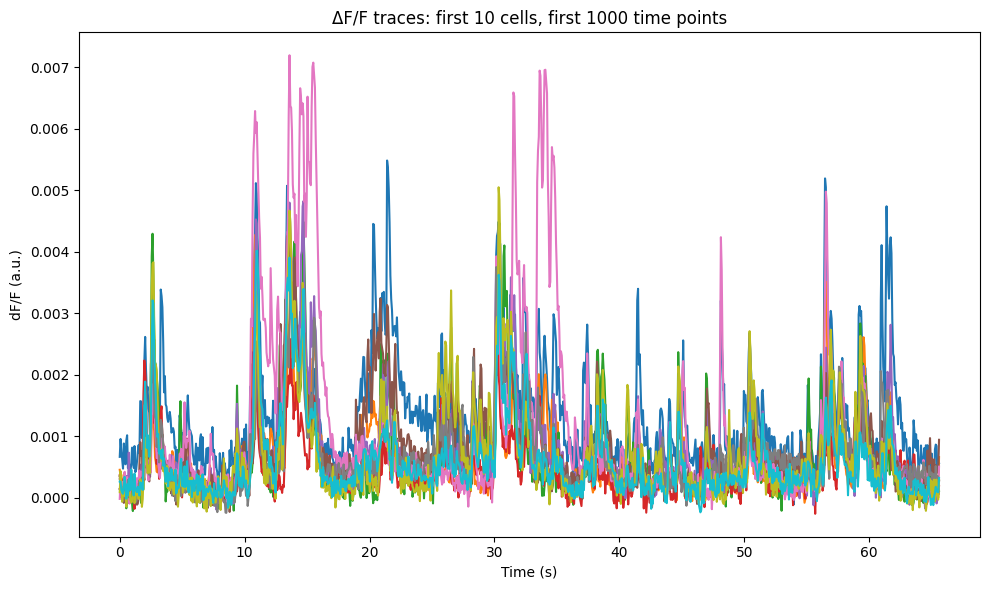

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Access dF/F data for all ROIs
dff = ophys.data_interfaces['Fluorescence'].roi_response_series['dff_chn0']
dff_data = dff.data[:1000, :10]  # first 1000 time points, first 10 cells
rate = dff.rate

# Plot ΔF/F traces for first 10 cells
plt.figure(figsize=(10, 6))
t = np.arange(dff_data.shape[0]) / rate
for i in range(dff_data.shape[1]):
    plt.plot(t, dff_data[:, i], label=f'Cell {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('dF/F (a.u.)')
plt.title('ΔF/F traces: first 10 cells, first 1000 time points')
plt.tight_layout()
plt.show()

These traces show each cell’s activity (ΔF/F) over time in arbitrary units. Different cells may have unique dynamics, and these population plots serve as a starting point for more advanced analyses.

## 6. Visualizing Event-like Calcium Traces

A common data product is "event" traces (e.g., via deconvolution), stored as `ca_events_chn0`. We can plot these for the same cells and epoch as above.

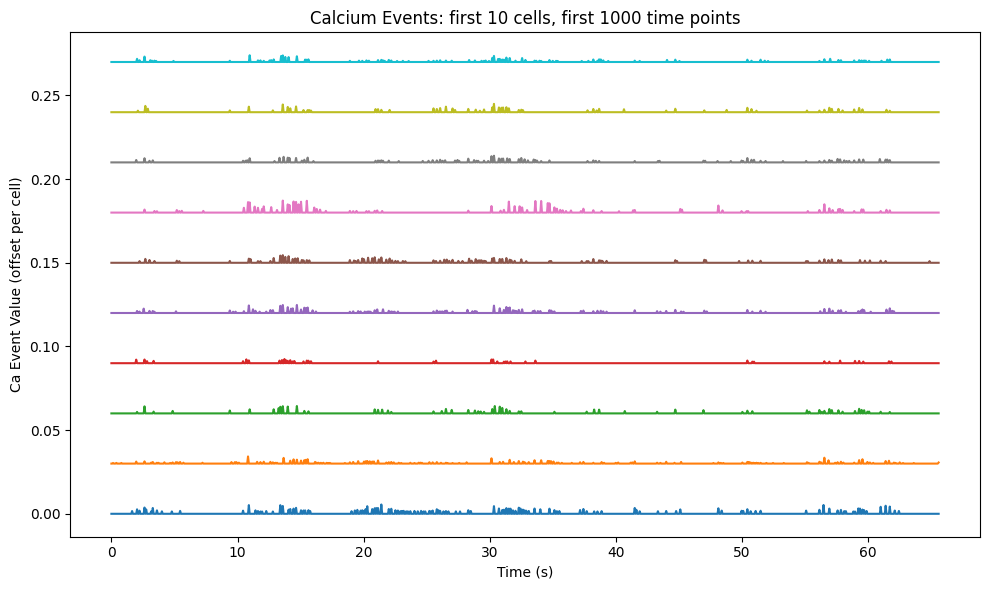

In [6]:
# Access and plot ca_events (event-like transients) for first 10 cells
caev = ophys.data_interfaces['Fluorescence'].roi_response_series['ca_events_chn0']
caev_data = caev.data[:1000, :10]

plt.figure(figsize=(10, 6))
t = np.arange(caev_data.shape[0]) / rate
for i in range(caev_data.shape[1]):
    plt.plot(t, caev_data[:, i] + i*0.03, label=f'Cell {i+1}')  # small offset per cell
plt.xlabel('Time (s)')
plt.ylabel('Ca Event Value (offset per cell)')
plt.title('Calcium Events: first 10 cells, first 1000 time points')
plt.tight_layout()
plt.show()

These event traces are sparser and highlight putative firing events for each cell. You can use these event-like series, or the continuous ΔF/F, according to your analytical goals.

## 7. Other Available Signals in `roi_response_series`

- **f_corrected_chn0:** Background-corrected fluorescence
- **fluorescence_chn0:** Raw fluorescence traces
- **neuropil_fluorescence_chn0:** Background neuropil signal
- **z_score_chn0:** Z-scored traces

For each, access the data array in the same way as the dF/F and events example. This enables diverse normalization and denoising strategies.

## 8. Accessing Synchronization and Behavioral Triggers

This dataset synchronized imaging and behavior via an LED signal. You may explore which TimeSeries objects correspond to triggers as follows:

In [7]:
# List all acquisition TimeSeries—look for LED or synchronization signals
print("Available TimeSeries in acquisition module:")
for key in nwb.acquisition:
    ts = nwb.acquisition[key]
    print(f"- {key}: {type(ts)}, description: {getattr(ts, 'description', '')}")

Available TimeSeries in acquisition module:


If relevant signals are found (for example, 'LED_trigger'), you can extract their timestamps and values as follows:

```python
led_ts = nwb.acquisition['LED_trigger']  # Replace with actual key name
led_data = led_ts.data[:]
led_timestamps = led_ts.timestamps[:] if led_ts.timestamps is not None else None
```

These data can be used to temporally align neural data with behavioral events.

## 9. Recommendations and Next Steps

- Use these code patterns to extract data for further analysis or visualization for any file/session.
- For interactive mask and signal exploration, consider a GUI viewer such as [Neurosift](https://neurosift.app/nwb?dandisetId=001349&dandisetVersion=0.250520.1729&path=sub-C57-C2-2-AL/sub-C57-C2-2-AL_ses-2_ophys.nwb).
- Take advantage of rich metadata for grouping sessions by age, treatment, or other factors.
- Consider exploring correlations, dynamical motifs, or event synchronization across the population.

**You are now ready to launch your own reanalyses, whether that's by expanding these scripts, incorporating more complex statistics, or integrating behavioral data. Happy analyzing!**